In [1]:
# work in progress

In [ ]:
# TODO

# General

# Exploratory Data Analysis
# check out https://github.com/salesforce/Merlion for anomaly detection
# check out MNE: https://mne.tools/stable/index.html

# Time series packages
# - tsfresh
# - tslearn 
# - pyts
# - sktime
# - aeon 
# - tsai
# - darts
# - merlion
# - https://github.com/thuml/Time-Series-Library


# Preprocessing 
# - for eeg check out mne: https://mne.tools/stable/index.html and https://github.com/sappelhoff/pyprep
# - find a sampling frequency that is high enough to capture the relevant information
#  -> thiam et al. 2021: 256 Hz, take a look at section 3.5 for more information and additional steps
# see https://pyts.readthedocs.io/en/stable/auto_examples/preprocessing/plot_scalers.html#sphx-glr-auto-examples-preprocessing-plot-scalers-py
# add group standardization? or just use robust scaler?
# -> could be important for transfer learning
# https://stackoverflow.com/questions/55601928/apply-multiple-standardscalers-to-individual-groups

# Data
# handling imbalanced data
#   - https://github.com/scikit-learn-contrib/imbalanced-learn
#   - https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
#   - oversampling the minority class, undersampling the majority class
#   - imblearn.over_sampling import RandomOverSampler
#   - SMOTE? https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/
#   -> quite controversial according to some guy on twitter
#   - https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
#   - https://twitter.com/predict_addict/status/1700467528969879886
# synthetic data generation
#   - TabDDPM: Modelling Tabular Data with Diffusion Models, https://arxiv.org/abs/2209.15421
#   - also see raschkas books
# self supervised learning (again raschka)
#   - must read https://www.techrxiv.org/articles/preprint/Applications_of_Self-Supervised_Learning_to_Biomedical_Signals_where_are_we_now/22567021/1/files/40045018.pdf

# Labels
# check out https://dl.acm.org/doi/abs/10.1145/3555776.3577721

# Skorch
# Define callbacks
#  - https://skorch.readthedocs.io/en/stable/callbacks.html
#  - email reminder for training
# take a look into basic usage notebook from the skorch documentation
# also check out mlflow for logging: https://mlflow.org/docs/latest/tracking.html
# change the path to the tensorboard logs (runs folder)
# check if softmax with default nll-criterion gives the same result as cross-entropy loss (it should)
#  -> bad idea for implementation, always use high level functions

# Models
# systematic literature review: Automatic assessment of pain based on deep learning methods
# correct input parameters for the models (see commented code underneath the model definition)
#   -> find out how this works with skorch, does it take input parameters from the model definition?
# add nn.Flatten() to the beginning of the MLP, simplify pipeline. maybe. or don't. doesn't have to be perfect.
#   - note that torch.flatten is not in Fortran order, so the resulting tensor is not contiguous
#   -> better question: does this change the performance of the model? (for CNNs pretty sure it does)
# and sktime
# add CatBoost
#  -> try to explain the model, e.g. with SHAP & boruta shap https://github.com/Ekeany/Boruta-Shap
#  -> also https://github.com/cerlymarco/shap-hypetune
# add MOS-CNN from https://github.com/Wensi-Tang/OS-CNN
# add CNN-LSTM
# add MLSTM-FCN from https://github.com/alexmelekhin/MLSTM-FCN-Pytorch
# time gpt: https://arxiv.org/abs/2310.03589 and https://news.ycombinator.com/item?id=37874891
# - https://github.com/thuml/Time-Series-Library

# Models (later on)
# remain sceptical of architectures that are not specifically designed for time series classification
# remain sceptical of transformers for now 
# take a deep dive: https://robjhyndman.com/hyndsight/python_time_series.html
# note that pytorch-forecasting can easily be used for classification
#   - https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/building.html#Classification
#   - https://pytorch-forecasting.readthedocs.io/en/stable/models.html
#   -> work through both sites
# also darts: https://unit8co.github.io/darts/index.html
# and https://github.com/timeseriesAI/tsai
# add TemporalFusionTransformer (later on)
#   - may be not possible
#   - also see https://stackoverflow.com/questions/76313665/classification-in-pytorch-forecastings-temporal-fusion-transformer
# add TodyNet (later on)
#   - quite complicated
#   - Q: the graph is nice for explaining the model, but will it be used if it does not compete with the best model?
# do not use ensemble models for now because they can be too slow in inference for real-time applications and not very interpretable
#   - although, some argue for the opposite: https://ai.googleblog.com/2021/11/model-ensembles-are-faster-than-you.html
# also, neural networks could be faster in inference than random forests, https://stats.stackexchange.com/a/216126
# try out pyts for time series classification
# https://www.statsmodels.org/stable/tsa.html
# pingouin

# Training
# check out pycaret first: https://pycaret.org/ to get an overview of what to do / the whole pipeline
# use randomizedgridsearch?: https://scikit-learn.org/stable/modules/grid_search.html#grid-search
# check out optuna: https://optuna.org/,
#   - skorch code: https://github.com/optuna/optuna-examples/blob/main/pytorch/skorch_simple.py
#   - paper: https://arxiv.org/pdf/1907.10902.pdf
# also check out ray tune: https://docs.ray.io/en/master/tune/index.html
#  - https://docs.ray.io/en/master/tune/tutorials/tune-sklearn.html
# and bayesian optimization for hyperparameter tuning: botorch in optuna?
# - check out https://github.com/pyRiemann/pyRiemann
# https://huggingface.co/autotrain

# Inference
# - winning lottery ticket hypothesis: https://arxiv.org/pdf/1803.03635.pdf
# - try pruning to reduce model size and latency: https://pytorch.org/tutorials/intermediate/pruning_tutorial.html

# XAI
# https://arxiv.org/pdf/2104.00950.pdf
# feature selection, feature extraction, feature importance, ...
# https://captum.ai/
# model agnostic methods like SHAP, LIME, 
#   - go through https://christophm.github.io/interpretable-ml-book/
#   - https://github.com/christophM/shap-book
#   - also read SHAPELY paper: https://arxiv.org/pdf/1705.07874.pdf
# This could be a perfect fit?!
#   - must read: https://arxiv.org/pdf/2208.05280.pdf
#   - code: https://github.com/fzi-forschungszentrum-informatik/TSInterpret 
#   - overview: https://joss.theoj.org/papers/10.21105/joss.05220

# Model Comparison
# see Raschkas paper section 4 for different ways / metrics https://arxiv.org/pdf/1811.12808.pdf
# plus MLxtend

# Deployment
# take a look at https://github.com/skops-dev/skops

# NOTE:
# don't just delete stuff from the todo list, put them in the done list here for now (+ git commit message)

# DONE


In [1]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')
    %load_ext autoreload
    %autoreload 2
    

In [2]:
import importlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from skorch import NeuralNetClassifier
from skorch.callbacks import TensorBoard
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GroupKFold, cross_val_score


from sklearn.metrics import (
    accuracy_score,
    matthews_corrcoef, 
    confusion_matrix, 
    ConfusionMatrixDisplay
    )

print(f"{torch.__version__ = }")
print(f"{torch.cuda.is_available() = }")

from src.features.scalers_3d import StandardScaler3D, MinMaxScaler3D, RobustScaler3D, MaxAbsScaler3D
from src.features.reshape_features_to_2d import reshape_features_to_2D

DATA_DIR = PROJECT_DIR / 'data' / 'dummy'
MODEL_DIR = PROJECT_DIR / 'models' / 'dummy'

torch.__version__ = '2.0.1'
torch.cuda.is_available() = False


In [6]:

writer = SummaryWriter()
callbacks = []
callbacks.append(TensorBoard(writer))

In [7]:
# Define MLP in pytorch
class MultiLayerPerceptron(nn.Module):
    def __init__(self, num_units=100):
        super().__init__()

        self.dense0 = nn.Linear(data.shape[1]*data.shape[2], num_units)
        self.nonlin = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, num_units)
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = self.nonlin(self.dense1(X))
        X = self.softmax(self.output(X))
        return X
    
"""
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)
"""

# Create MLP with skorch
mlp = NeuralNetClassifier(
    MultiLayerPerceptron,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=callbacks
)

In [10]:
# Define LSTM with pytorch
class LongShortTermMemory(nn.Module):
    def __init__(self, num_units=10):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=data.shape[2],
            hidden_size=num_units,
            num_layers=1,
            batch_first=True
        )
        self.output = nn.Linear(num_units, 2)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, X, **kwargs):
        X, _ = self.lstm(X)
        X = self.softmax(self.output(X[:, -1, :]))
        return X


# Create LSTM with skorch
lstm = NeuralNetClassifier(
    LongShortTermMemory,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=callbacks
)




### Load data

In [16]:

data = np.load(DATA_DIR / "data.npy").astype(np.float32)
target = np.load(DATA_DIR / "target.npy").astype(np.int64)
groups = np.load(DATA_DIR / "groups.npy").astype(np.int64)

print(f"{data.shape = }\n{target.shape = }\n{groups.shape = }")


data.shape = (4000, 500, 3)
target.shape = (4000,)
groups.shape = (4000,)


## Modeling

In [ ]:
# Create pipelines with sklearn
mlp_pipe = make_pipeline(
    StandardScaler3D(),
    FunctionTransformer(reshape_features_to_2D), 
    mlp)

lstm_pipe = make_pipeline(
    MinMaxScaler3D(),
    lstm)

In [ ]:
mlp_pipe.fit(data, target)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4268       0.8300        0.2952  0.2084
      2        0.3573       0.7725        0.3045  0.1546
      3        0.3523       0.8037        0.2928  0.1546
      4        0.3477       0.8237        0.2874  0.1685
      5        0.3487       0.8263        0.2892  0.1496
      6        0.3450       0.8113        0.2909  0.1496
      7        0.3439       0.8100        0.2898  0.1626
      8        0.3446       0.7738        0.3029  0.1336
      9        0.3456       0.8313        0.2882  0.1526
     10        0.3448       0.7850        0.2943  0.1486


Pipeline(steps=[('standardscaler3d', StandardScaler3D()),
                ('functiontransformer',
                 FunctionTransformer(func=<function reshape_features_to_2D at 0x00000232CF4E3010>)),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MultiLayerPerceptron(
    (dense0): Linear(in_features=1500, out_features=100, bias=True)
    (nonlin): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=100, out_features=100, bias=True)
    (output): Linear(in_features=100, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))])

In [ ]:
lstm_pipe.fit(data, target)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6921       0.6550        0.6883  2.2476
      2        0.6871       0.7638        0.6817  2.1812
      3        0.6806       0.7500        0.6730  2.1839
      4        0.6714       0.7825        0.6597  2.1610
      5        0.6564       0.7550        0.6362  2.1294
      6        0.6267       0.7500        0.5869  2.1862
      7        0.5590       0.7562        0.4799  2.0195
      8        0.4840       0.8250        0.4100  1.7523
      9        0.4506       0.8250        0.3774  1.7603
     10        0.4312       0.8063        0.3633  1.7906


Pipeline(steps=[('minmaxscaler3d', MinMaxScaler3D()),
                ('neuralnetclassifier',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LongShortTermMemory(
    (lstm): LSTM(3, 10, batch_first=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
    (softmax): Softmax(dim=-1)
  ),
))])

# Test data

In [ ]:
# Load data
data_test = np.load(DATA_DIR / "data_test.npy").astype(np.float32)
target_test = np.load(DATA_DIR / "target_test.npy").astype(np.float32)

print(f"{data_test.shape = }\n{target_test.shape = }")

data_test.shape = (800, 500, 3)
target_test.shape = (800,)


Metrics for MLP classifier:
acc = 0.67375
mcc = 0.3919382392457072


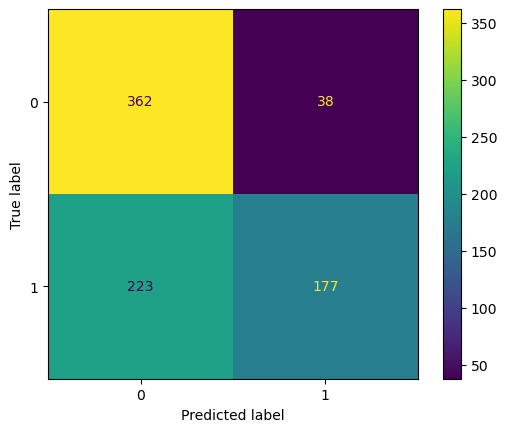

In [ ]:
# Metrics for MLP classifier

target_predicted = mlp_pipe.predict(data_test)

cm = confusion_matrix(target_test, target_predicted)
acc = accuracy_score(target_test, target_predicted)
mcc = matthews_corrcoef(target_test, target_predicted)

ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=mlp_pipe.classes_,
    ).plot()

print("Metrics for MLP classifier:")
print(f"{acc = }\n{mcc = }")


In [ ]:
mlp_score = mlp_pipe.score(data_test, target_test)
print(f"{mlp_score = }")

lstm_score = lstm_pipe.score(data_test, target_test)
print(f"{lstm_score = }")


mlp_score = 0.67375
lstm_score = 0.68625


scores on the test data are much lower than on the train data -> the model clearly overfits non-grouped data

# GroupKFold cross-validation 
(doing it right)

In [ ]:
cv = GroupKFold(n_splits=5)
test_score = cross_val_score(
    mlp_pipe,
    data, target,
    groups=groups,
    cv=cv,
    n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")


The average accuracy is 0.764 ± 0.029


In [ ]:
test_score

array([0.7425 , 0.74625, 0.725  , 0.8    , 0.75   ])

In [ ]:
cv = GroupKFold()
test_score = cross_val_score(
    lstm_pipe,
    data, 
    target, 
    groups=groups,
    cv=cv, 
    n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")


The average accuracy is 0.753 ± 0.025


## Skorch doctor

In [4]:
from skorch.helper import SkorchDoctor
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)



# Grid search


# More stuff (WIP)

Average difference of 0.007581 with std. dev. of 0.007833.


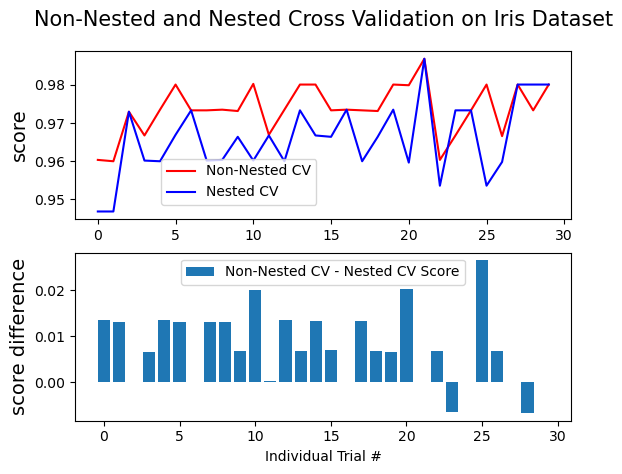

In [ ]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

# Number of random trials
NUM_TRIALS = 30

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()

In [ ]:
# # with grid search
# from sklearn.model_selection import GridSearchCV

# # deactivate skorch-internal train-valid split and verbose logging
# net.set_params(train_split=False, verbose=0)
# params = {
#     'lr': [0.01, 0.02],
#     'max_epochs': [10, 20],
#     'module__num_units': [100, 1000],
# }
# gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

# gs.fit(data, target)
# print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

# Test set

In [ ]:
# Load data
data_test = np.load(Path(r"data/data_test.npy"))
target_test = np.load(Path(r"data/target_test.npy"))

# Scale data
data_test = StandardScaler3D().fit_transform(data_test)

# Reshape X to 1-D for MLP
data_test = np.reshape(data_test, (
    data_test.shape[0],
    data_test.shape[2]*data_test.shape[1]
), order="F")

plt.plot(data_test[142]);
print(f"{data_test.shape = }")

FileNotFoundError: [Errno 2] No such file or directory: 'data\\data_test.npy'

## Sklearn implementation


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GroupKFold

model = MLPClassifier(
    random_state=1, 
    max_iter=500, 
    early_stopping=True)

cv = GroupKFold()
test_score = cross_val_score(model, data, target, groups=groups, cv=cv,
                             n_jobs=5)
print(f"The average accuracy is "
      f"{test_score.mean():.3f} ± "
      f"{test_score.std():.3f}")

In [ ]:
all_scores = pd.DataFrame(
    [test_score],
    index=["KFold with groups"],
).T

all_scores.plot.hist(bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Accuracy score")
_ = plt.title("Distribution of the test scores")

# Tests

In [ ]:
# test for tranform_to_1d

# Reshape X to 1-D for MLP
data = np.reshape(data, (
    data.shape[0],
    data.shape[2]*data.shape[1]
), order="F")

plt.plot(data[142]);
print(f"{data.shape = }")

In [ ]:
from sklearn.model_selection import GroupKFold
X = range(100)
y = target[:100]
groups_ = groups[:1000:10]
gkf = GroupKFold(n_splits=6)
for train, test in gkf.split(X, y, groups=groups_):
    print("%s %s" % (train, test))
    print(f"{train.shape = }\n{test.shape = }")